<a href="https://colab.research.google.com/github/hyunicecream/ML-DL/blob/main/CNN%20%EC%8B%9C%EA%B3%84%EC%97%B4%20Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 2차원 배열의 feature 데이터로 CNN 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = [data[i:(i+t_step), :] for i in m]      # feature data
    y = [data[i, :] for i in (m + t_step)]      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = np.reshape(np.array(x), (len(m), t_step, n_feat))
    y_target = np.reshape(np.array(y), (len(m), n_feat))
    
    return x_data, y_target

In [ ]:
# 시계열 데이터 (noisy sin)
n_data = 1000
# sine = np.sin(2 * np.pi * 0.03 * np.arange(n_data))   # sine 곡선
sine = np.sin(2 * np.pi * 0.03 * np.arange(n_data)) + np.random.random(n_data) # noisy sine

# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
# 미래의 sine 값을 target으로 만들어 주고, CNN을 학습한다.
df = pd.DataFrame({'sine':sine})
df.head()

,sine
0,0.900010
1,0.693949
2,0.501697
3,0.969908
4,1.652944


In [ ]:
t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape

((980, 20, 1), (980, 1))

In [ ]:
# Convolutional 1D 모델을 생성한다.
n_feat = 1

x_input = Input(batch_shape = (None, t_step, n_feat))
x_conv = Conv1D(filters=30, kernel_size=8, strides=1, padding = 'valid', activation='relu')(x_input)
x_pool = MaxPooling1D(pool_size=4, strides=1, padding='valid')(x_conv)
x_flat = Flatten()(x_pool)
y_output = Dense(1, activation='linear')(x_flat)

model = Model(x_input, y_output)
model.compile(loss='mse', optimizer = optimizers.Adam(learning_rate=0.005))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 13, 30)            270       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 30)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_______________________________________________________________

In [ ]:
# 모델을 학습한다.
h = model.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 1s 5ms/step - loss: 0.1873
Epoch 2/50
31/31 [==============================] - 0s 4ms/step - loss: 0.1098
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0924
Epoch 4/50
31/31 [==============================] - 0s 4ms/step - loss: 0.1012
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.0919
Epoch 6/50
31/31 [==============================] - 0s 4ms/step - loss: 0.0899
Epoch 7/50
31/31 [==============================] - 0s 4ms/step - loss: 0.0901
Epoch 8/50
31/31 [==============================] - 0s 4ms/step - loss: 0.0967
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0856
Epoch 10/50
31/31 [==============================] - 0s 3ms/step - loss: 0.0854
Epoch 11/50
31/31 [==============================] - 0s 4ms/step - loss: 0.0900
Epoch 12/50
31/31 [==============================] - 0s 4ms/step - loss: 0.0870
Epoch 13/50
31/31 [==============================

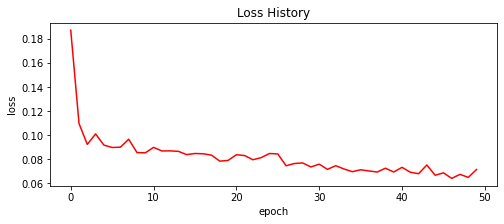

In [ ]:
# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
n_future = 20
n_last = 100
if len(data) > n_last:
    last_data = np.copy(data[-n_last:])  # 원 데이터의 마지막 n_last개만 그려본다
else:
    last_data = np.copy(data)

dx = np.copy(last_data)
estimated = [dx[-1][0]]
for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = dx[-t_step:].reshape(1, t_step, 1)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px)[0][0]
        
    # 예측값을 저장해 둔다
    estimated.append(y_hat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), y_hat)

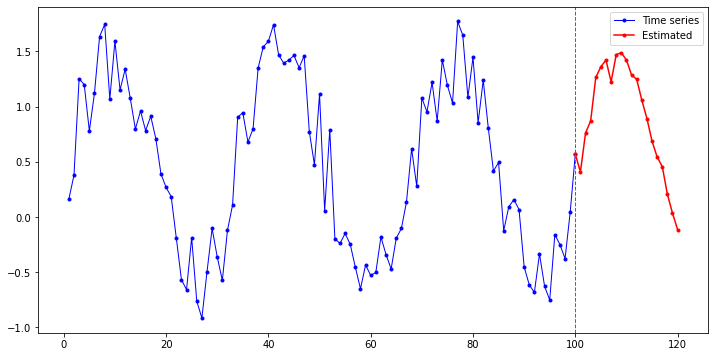

In [ ]:
# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(last_data) + 1)
ax2 = np.arange(len(last_data), len(last_data) + len(estimated))
plt.plot(ax1, last_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimated, 'b-o', color='red', markersize=3, label='Estimated')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()